# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

Thanks to [RealWaste: A Novel Real-Life Data Set for Landfill Waste Classification Using Deep Learning](https://www.mdpi.com/2078-2489/14/12/633).

## Part 1: Setup

### 1.1 Load Libraries

In [1]:
# Import necessary libraries
# General Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os

#Processing Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

#Handling Text
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# Network Building
from tensorflow import keras
from keras import Sequential, Input, Model
from keras.layers import Layer, Dense, Dropout, Conv2D, Flatten, MaxPooling2D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


#GRU
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### 1.2 Load Datasets

In [2]:
# Point to path and make sure it exists.
img_path = 'realwaste-main/RealWaste/'
if(os.path.exists(img_path)):
    print("Good to go!")
else:
    print(f"Path, {img_path}, does not exist")

Good to go!


In [3]:
documents = pd.read_json('waste_policy_documents.json')

In [4]:
descriptions = pd.read_csv('waste_descriptions.csv')

## Part 2: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.
- Dataset structure
- Distribution of waste categories
- Image characteristics (resolution, quality, background)

### 2.1:  Inspect Images

We have a folder for each type of image, labeled by type.  Files within each folder have the syntax of 'type_#.jpg'

In [5]:
class_sizes = {}
for path,_,files in os.walk(img_path):
    cat = path.split('/')[-1]
    if(cat==""):
        pass
    else:
        class_sizes[cat]=len(files)

print(f'Total Observations: {sum(size for size in class_sizes.values())}')
print(f'Split into {len(class_sizes)} categories:')
print(class_sizes)

Total Observations: 4752
Split into 9 categories:
{'Paper': 500, 'Metal': 790, 'Cardboard': 461, 'Food Organics': 411, 'Glass': 420, 'Vegetation': 436, 'Textile Trash': 318, 'Miscellaneous Trash': 495, 'Plastic': 921}


So slightly imbalanced with Metal (700) and Plastics (921).

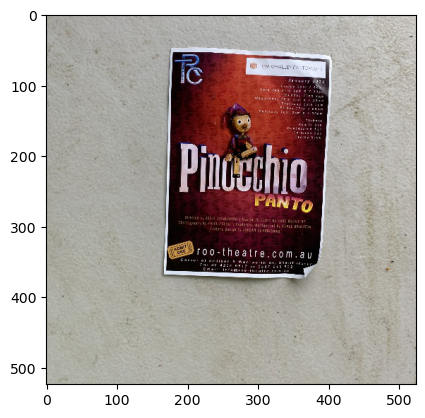

In [6]:
sample_path = img_path + 'Paper/Paper_1.jpg'
img = mpimg.imread(sample_path)
plt.imshow(img);

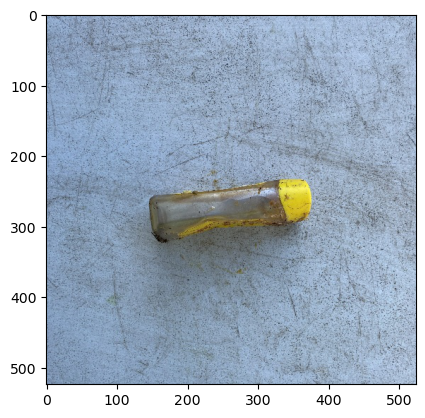

In [7]:
sample_path = img_path + 'Plastic/Plastic_21.jpg'
img = mpimg.imread(sample_path)
plt.imshow(img);

These are just two samples but it would appear that we have an object, generally centered, against a plain backdrop but not necessarily consistent color/tone.

### 2.2: Inspect documents
- Understand document organization and language

In [8]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   policy_id           14 non-null     int64 
 1   policy_type         14 non-null     object
 2   categories_covered  14 non-null     object
 3   effective_date      14 non-null     object
 4   document_text       14 non-null     object
 5   jurisdiction        14 non-null     object
dtypes: int64(1), object(5)
memory usage: 804.0+ bytes


14 entries

In [9]:
print(documents.iloc[0])
print(documents.iloc[0]['document_text'])

policy_id                                                             1
policy_type                          Textile Trash Recycling Guidelines
categories_covered                                      [Textile Trash]
effective_date                                               2023-11-04
document_text         TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...
jurisdiction                                                 Metro City
Name: 0, dtype: object
TEXTILE RECYCLING GUIDELINES

Acceptable Items:
- Clean clothing (all conditions)
- Towels, sheets, and linens
- Fabric scraps
- Curtains and cloth napkins
- Handbags and backpacks made of fabric
- Soft toys and stuffed animals

Non-Acceptable Items:
- Wet or moldy textiles
- Heavily soiled items
- Carpets and rugs
- Footwear
- Items with significant non-textile parts

Collection Method:
Place items in dedicated textile recycling bins or donate to local thrift stores.

Preparation Instructions:
- Ensure all items are clean and dry
- Remove

In [10]:
print(documents.iloc[2])
print(documents.iloc[2]['document_text'])

policy_id                                                             3
policy_type                          Food Organics Recycling Guidelines
categories_covered                                      [Food Organics]
effective_date                                               2023-05-08
document_text         FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...
jurisdiction                                                 Metro City
Name: 2, dtype: object
FOOD ORGANICS RECYCLING GUIDELINES

Acceptable Items:
- Fruit and vegetable scraps
- Meat and fish (including bones)
- Dairy products
- Bread and grains
- Coffee grounds and tea bags
- Eggshells
- Leftovers and spoiled food

Non-Acceptable Items:
- Packaging of any kind
- Stickers on produce
- Non-compostable bags
- Liquids (drain first)
- Grease or cooking oil

Collection Method:
Use dedicated food waste bins lined with compostable bags.

Preparation Instructions:
- Remove all packaging
- Drain excess liquids
- Use compostable bags if req

So the text of these documents includes:

-a list of acceptable items; 

-a list of unacceptable items;

-a description of collection;

-a list of instructions for preparation

-a description of the benefits.

It therefore may make sense (and easy) to manipulate these strings to remove the formatting.

Let's make sure that the other data in documents doesn't have any surprises:

In [11]:
documents.jurisdiction.value_counts()

jurisdiction
Metro City    14
Name: count, dtype: int64

In [12]:
documents.policy_type.value_counts()

policy_type
Textile Trash Recycling Guidelines          1
Glass Recycling Guidelines                  1
Food Organics Recycling Guidelines          1
Plastic Recycling Guidelines                1
Vegetation Recycling Guidelines             1
Cardboard Recycling Guidelines              1
Metal Recycling Guidelines                  1
Paper Recycling Guidelines                  1
Miscellaneous Trash Recycling Guidelines    1
Municipal Waste Guidelines                  1
Residential Recycling Rules                 1
Commercial Recycling Standards              1
Multi-Unit Building Guidelines              1
Community Recycling Program                 1
Name: count, dtype: int64

In [13]:
documents.effective_date.value_counts()

effective_date
2023-11-04    1
2023-01-24    1
2023-05-08    1
2023-04-05    1
2023-12-04    1
2023-11-24    1
2023-09-03    1
2023-10-14    1
2023-01-01    1
2023-10-01    1
2023-05-26    1
2023-05-05    1
2023-07-04    1
2023-12-15    1
Name: count, dtype: int64

In [14]:
documents.categories_covered

0                                       [Textile Trash]
1                                               [Glass]
2                                       [Food Organics]
3                                             [Plastic]
4                                          [Vegetation]
5                                           [Cardboard]
6                                               [Metal]
7                                               [Paper]
8                                 [Miscellaneous Trash]
9            [Plastic, Miscellaneous Trash, Vegetation]
10    [Plastic, Metal, Glass, Miscellaneous Trash, V...
11          [Food Organics, Metal, Miscellaneous Trash]
12                    [Cardboard, Glass, Textile Trash]
13        [Cardboard, Vegetation, Metal, Textile Trash]
Name: categories_covered, dtype: object

So the # of topics covered in each document is not consistent.  Especially, document 10.

In [15]:
print(documents.iloc[10])
print(documents.iloc[10].document_text)

policy_id                                                            11
policy_type                                 Residential Recycling Rules
categories_covered    [Plastic, Metal, Glass, Miscellaneous Trash, V...
effective_date                                               2023-05-26
document_text         RESIDENTIAL RECYCLING RULES\n\nGENERAL REQUIRE...
jurisdiction                                                 Metro City
Name: 10, dtype: object
RESIDENTIAL RECYCLING RULES

GENERAL REQUIREMENTS:
- Place recyclables in appropriate bins
- Ensure materials are clean and properly sorted
- Follow collection schedules
- Keep hazardous materials separate


PLASTIC GUIDELINES:
- PET bottles and containers (code #1)
- HDPE containers (code #2)
- PP containers (code #5)
- Clean plastic packaging
- Plastic bags and film

METAL GUIDELINES:
- Aluminum cans
- Steel food cans
- Metal lids and bottle caps
- Clean aluminum foil
- Empty aerosol cans

GLASS GUIDELINES:
- Glass bottles (all colors)


### 2.3:  Inspect Descriptions
- Analyze vocabulary and structure
- Understand the distribution of categories

In [16]:
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   description           5000 non-null   object
 1   category              5000 non-null   object
 2   disposal_instruction  5000 non-null   object
 3   common_confusion      2496 non-null   object
 4   material_composition  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


5k entries w/ 5 features.

In [17]:
descriptions.head()

,description,category,disposal_instruction,common_confusion,material_composition
0,soiled silver tablecloth,Textile Trash,Look for textile recycling programs in your area.,NaN,"Fabric made from natural or synthetic fibers, ..."
1,folded glass bottle leaking,Glass,"Remove caps, lids, and corks before recycling.",NaN,"Silica-based material, may contain additives f..."
2,large Supermarket vegetable waste with food re...,Food Organics,"If no compost available, place in general waste.",NaN,Biodegradable matter derived from plant or ani...
3,intact floral carpet piece,Textile Trash,Look for textile recycling programs in your area.,NaN,"Fabric made from natural or synthetic fibers, ..."
4,empty fun-sized purple apple core,Food Organics,Keep separate from recyclable materials.,Meat and dairy products may be restricted in s...,Biodegradable matter derived from plant or ani...


In [18]:
descriptions.category.value_counts()

category
Vegetation             600
Textile Trash          586
Cardboard              584
Miscellaneous Trash    578
Plastic                569
Glass                  551
Food Organics          518
Metal                  508
Paper                  506
Name: count, dtype: int64

Does not appear to be a class balance concern...

In [19]:
descriptions.isna().sum()

description                0
category                   0
disposal_instruction       0
common_confusion        2504
material_composition       0
dtype: int64

What should be done with the common confusion entries which are "missing".  Let's first take a look @ the distribution of this feature.

In [20]:
descriptions.common_confusion.value_counts(dropna=False)

common_confusion
NaN                                                                                                         2504
Invasive species may require special disposal. Large branches might need separate collection.                315
Some textiles can be recycled or donated, even if worn or torn.                                              305
Plastic bags often can not go in general recycling. Check for recycling numbers (1-7) on containers.         291
Window glass, drinking glasses, and ceramics should not go in container glass recycling.                     283
Pizza boxes with food stains should go in organic waste or general trash, not recycling.                     271
Check for hidden recyclable components before disposal.                                                      270
Meat and dairy products may be restricted in some composting systems.                                        257
Items with mixed materials should be separated if possible. Check if your facil

These are specific instructions (as opposed to some unformatted/inconsisten text or list) but I think it will make sesne to fill these missing entries with a string 'None' since I interpret the lack of value being a lack of confusion.

In [21]:
descriptions.disposal_instruction.value_counts(dropna=False)

disposal_instruction
Rinse container before recycling.                                               239
If no recycling options exist, place in general waste.                          134
Place in green waste bin or compost.                                            132
Some municipalities offer special collection services.                          130
Remove labels if possible.                                                      125
Some retailers accept old clothing for recycling.                               124
Electronics should be taken to e-waste collection points.                       124
Flatten boxes before placing in cardboard recycling.                            122
Check if your area has seasonal leaf collection.                                122
Consider donating if still usable.                                              120
Consider if items can be repaired or repurposed.                                118
If contaminated with food, tear off contaminated parts.

In [22]:
descriptions[descriptions.category=='Vegetation'].material_composition.value_counts(dropna=False)

material_composition
Plant matter composed primarily of cellulose and lignin.    600
Name: count, dtype: int64

In [23]:
descriptions.description.value_counts(dropna=False)

description
glass tabletop                                        3
clamshell packaging                                   3
water bottle                                          3
CD case                                               3
glass sheet                                           3
                                                     ..
industrial purple potted plant                        1
compact patterned packaging box with liquid inside    1
travel-sized patterned Generic plastic tray           1
full small Artisanal drinking glass                   1
blue Designer detergent bottle                        1
Name: count, Length: 4939, dtype: int64

#### Let's look at word clouds for the description feature.

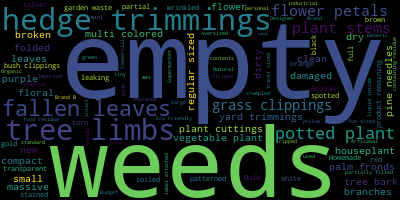

In [24]:
txt = '.  '.join(descriptions[descriptions.category=='Vegetation']['description'])
cloud = WordCloud(max_words=100)
cloud.generate(txt)
cloud.to_image()

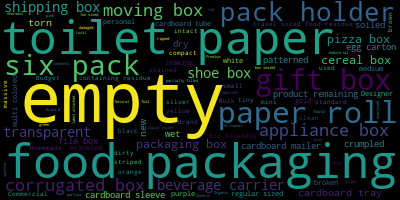

In [25]:
txt = '.  '.join(descriptions[descriptions.category=='Cardboard']['description'])
cloud = WordCloud(max_words=100)
cloud.generate(txt)
cloud.to_image()

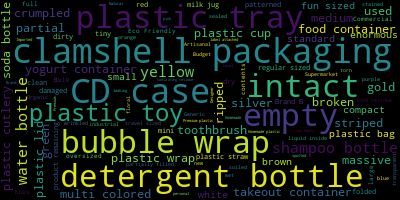

In [26]:
txt = '.  '.join(descriptions[descriptions.category=='Plastic']['description'])
cloud = WordCloud(max_words=100)
cloud.generate(txt)
cloud.to_image()

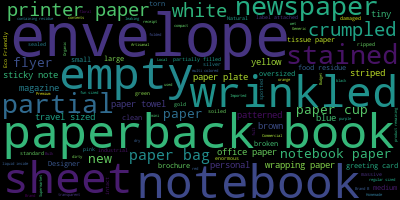

In [27]:
txt = '.  '.join(descriptions[descriptions.category=='Paper']['description'])
cloud = WordCloud(max_words=100)
cloud.generate(txt)
cloud.to_image()

It looks like there is some very promising seperation in these descriptions.

### 3: Create Data Pipelines

#### 3.1:  For Images

In [28]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
data_dir = pathlib.Path(img_path)

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH) + (3,)

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


In [29]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

#### 3.2: For Text Data

In [30]:
class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [31]:
descriptions.category.value_counts()

category
Vegetation             600
Textile Trash          586
Cardboard              584
Miscellaneous Trash    578
Plastic                569
Glass                  551
Food Organics          518
Metal                  508
Paper                  506
Name: count, dtype: int64

We will focus on classifying on the description feature since disposal instruction and material composition seem to be determined by which category they fall under (more or less).

##### For Solution A (TdIF + Multinomial NB)

In [32]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Your code here

In [33]:
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization function
def lemmatize_tokens(tokens):
    """
    Lemmatize tokens with appropriate POS tags
    
    Parameters:
    tokens (list): List of word tokens
    
    Returns:
    list: Lemmatized tokens
    """
    # Tag tokens with parts of speech
    tokens_tagged = nltk.pos_tag(tokens)
    
    # Convert to WordNet POS tags
    pos_tokens = [(word[0],get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Lemmatize with POS tags
    lemmatized = [lemmatizer.lemmatize(word[0],word[1]) for word in pos_tokens]
    
    return lemmatized

In [34]:

def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    # Convert to lowercase
    clean_txt = text.lower()
    # Remove special characters/numbers
    clean_txt = re.sub(r'[^a-zA-Z0-9 ]', '', clean_txt)
    # Tokenize
    tokens = word_tokenize(clean_txt)
    filtered_tokens = [token for token in tokens if not token.isnumeric()]
    filtered_tokens = [token for token in tokens if len(token) > 0]
    # Optional: Remove stopwords
    
    filtered_tokens = [token for token in filtered_tokens if token not in stop_words]
    
    # Lemmatize or stem tokens
    final_tokens = lemmatize_tokens(filtered_tokens)
    # Return the cleaned token list
    txt = ' '.join(final_tokens)
    return txt,final_tokens

In [35]:

def tdif_split(X_train,X_test,limitations=(0.0,1.0)):
    # Create a TfidfVectorizer object
    vectorizer = TfidfVectorizer(min_df=limitations[0],max_df=limitations[1])

    # Fit w/ training data
    tfidf_matrix = vectorizer.fit(X_train)

    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Transform and convert the TF-IDF matrix to an array
    tfidf_matrix_train = vectorizer.transform(X_train)
    tfidf_array_train = tfidf_matrix_train.toarray()
    tfidf_matrix_test = vectorizer.transform(X_test)
    tfidf_array_test = tfidf_matrix_test.toarray()
    return tfidf_array_train, tfidf_array_test

For Solution B (BERT):

In [36]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Your code here

#### 3.3: For Documents

TODO: Prepare documents for RAG

- Document preprocessing

- Create embeddings for retrieval

The metadata in this case is the policy type, the categories covered, and effective date.  (I am not going to bother collecting jursidiction since they all come from the same one.)

In [37]:
documents

,policy_id,policy_type,categories_covered,effective_date,document_text,jurisdiction
0,1,Textile Trash Recycling Guidelines,[Textile Trash],2023-11-04,TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...,Metro City
1,2,Glass Recycling Guidelines,[Glass],2023-01-24,GLASS RECYCLING GUIDELINES\n\nAcceptable Items...,Metro City
2,3,Food Organics Recycling Guidelines,[Food Organics],2023-05-08,FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...,Metro City
3,4,Plastic Recycling Guidelines,[Plastic],2023-04-05,PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...,Metro City
4,5,Vegetation Recycling Guidelines,[Vegetation],2023-12-04,VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...,Metro City
5,6,Cardboard Recycling Guidelines,[Cardboard],2023-11-24,CARDBOARD RECYCLING GUIDELINES\n\nAcceptable I...,Metro City
6,7,Metal Recycling Guidelines,[Metal],2023-09-03,METAL RECYCLING GUIDELINES\n\nAcceptable Items...,Metro City
7,8,Paper Recycling Guidelines,[Paper],2023-10-14,PAPER RECYCLING GUIDELINES\n\nAcceptable Items...,Metro City
8,9,Miscellaneous Trash Recycling Guidelines,[Miscellaneous Trash],2023-01-01,MISCELLANEOUS TRASH GUIDELINES\n\nItems That C...,Metro City
9,10,Municipal Waste Guidelines,"[Plastic, Miscellaneous Trash, Vegetation]",2023-10-01,MUNICIPAL WASTE GUIDELINES\n\nGENERAL REQUIREM...,Metro City


In [38]:
content = list(documents['document_text'])

In [39]:
create_meta = lambda r:{'type':r['policy_type'],'coverage':r['categories_covered'],'effective':r['effective_date']}

In [40]:
meta_data = documents.apply(create_meta,axis=1)

In [41]:
knowledge_base = pd.DataFrame({'content':content,'metadata':meta_data})

In [42]:
print(f"Knowledge base loaded with {len(knowledge_base)} entries")
knowledge_base.head(2)

Knowledge base loaded with 14 entries


,content,metadata
0,TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...,"{'type': 'Textile Trash Recycling Guidelines',..."
1,GLASS RECYCLING GUIDELINES\n\nAcceptable Items...,"{'type': 'Glass Recycling Guidelines', 'covera..."


In [43]:
def create_document_embeddings(documents):
    """
    Create embeddings for a list of documents.
    
    Args:
        documents: List of text documents to embed
        
    Returns:
        Numpy array of document embeddings
    """
    # Initialize a sentence transformer model
    
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  
    
    # Generate embeddings for all documents
    # Hint: Use the model.encode() method
    document_embeddings = embedding_model.encode(knowledge_base['content'].to_list(),show_progress_bar=True) 
    return document_embeddings

## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images
Processing will be done within the model.  As you can see in the UDF

### 2.2 Implement CNN Model with Transfer Learning

In [44]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Your code here
def build_img_classifier():
    base_model = ResNet50(input_shape=IMG_SHAPE,weights='imagenet',include_top=False)
    base_model.trainable = False
    inputs_tensor = Input(shape=IMG_SHAPE,name='image')
    x = preprocess_input(inputs_tensor)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D(name='')(x)
    x = Dropout(0.2)(x)
    prediction_layer = Dense(9,activation='softmax')
    outputs = prediction_layer(x)
    classifier = Model(inputs_tensor,outputs)
    return classifier

In [45]:
img_model = build_img_classifier()
img_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ image[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ image[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│  (GlobalAveragePoo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ [0][0]            │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9)         │     18,441 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [46]:
loss_func=tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy')]
base_learning_rate = 0.001

In [47]:
optimum = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
img_model.compile(optimizer=optimum,loss=loss_func,metrics=metrics)
original_epochs = 5

### 2.3: Train and Evaluate the Model

#### Training

In [48]:
history = img_model.fit(train_ds,validation_data=validation_ds,epochs=original_epochs)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 109s 905ms/step - accuracy: 0.4497 - loss: 1.6593 - val_accuracy: 0.7574 - val_loss: 0.7002
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 110s 928ms/step - accuracy: 0.7857 - loss: 0.6336 - val_accuracy: 0.8128 - val_loss: 0.6031
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 107s 899ms/step - accuracy: 0.8215 - loss: 0.5024 - val_accuracy: 0.7957 - val_loss: 0.5680
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 107s 896ms/step - accuracy: 0.8627 - loss: 0.3888 - val_accuracy: 0.8128 - val_loss: 0.5467
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 108s 909ms/step - accuracy: 0.8771 - loss: 0.3508 - val_accuracy: 0.8234 - val_loss: 0.5465


#### Evaluate & Look for Error Patterns

In [49]:
# Evaluate the model on test data
loss, accuracy = img_model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test Loss: {loss:.3f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 833ms/step - accuracy: 0.7967 - loss: 0.5423
Test accuracy: 0.808
Test Loss: 0.519


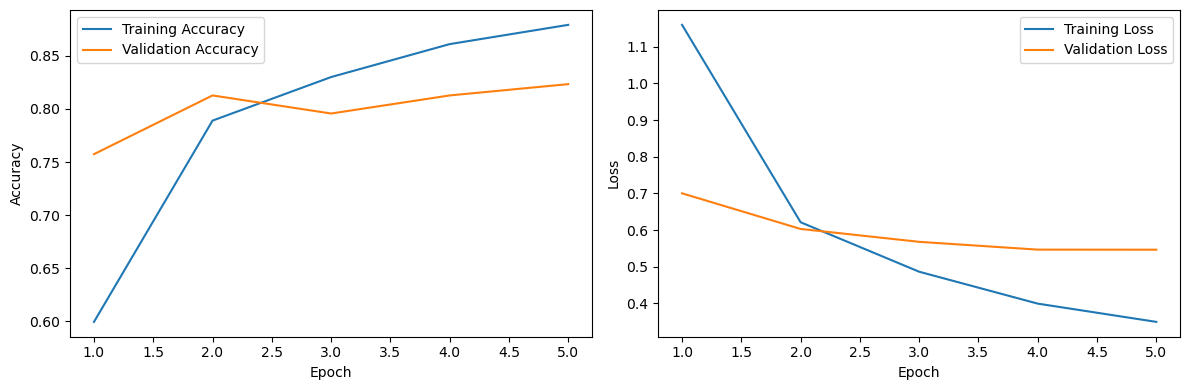

In [50]:
# Plot training metrics
def plot_history(history):
    e = len(history.history['accuracy']) + 1
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1,e),acc, label='Training Accuracy')
    plt.plot(range(1,e),val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1,e),loss, label='Training Loss')
    plt.plot(range(1,e),val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [51]:
test_predictions = img_model.predict(test_dataset)
predictions = pd.DataFrame(test_predictions)
predictions['est'] = predictions.apply(lambda r:np.argmax(r),axis=1)
predictions['true'] = np.argmax(np.concatenate([y for x,y in test_dataset],axis=0),axis=1)
predictions


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 949ms/step


2025-05-24 19:13:15.149447: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,0,1,2,3,4,5,6,7,8,est,true
0,0.454468,5.026290e-07,0.001239,0.001579,0.000321,0.522593,0.017876,1.923831e-03,5.605795e-08,5,5
1,0.071031,5.577672e-05,0.000326,0.904049,0.010006,0.002127,0.000316,1.203252e-02,5.630346e-05,3,3
2,0.025904,3.803167e-05,0.002490,0.654851,0.005954,0.000873,0.309129,7.436807e-04,1.730943e-05,3,3
3,0.000152,2.919139e-06,0.003237,0.045368,0.000052,0.000276,0.950837,7.479695e-05,9.653045e-08,6,6
4,0.000019,1.912570e-07,0.000017,0.000043,0.999775,0.000013,0.000131,6.846211e-07,6.361016e-07,4,4
...,...,...,...,...,...,...,...,...,...,...,...
475,0.004848,1.642838e-02,0.001479,0.004159,0.323770,0.012123,0.033907,6.018961e-01,1.389542e-03,7,4
476,0.019144,2.412970e-02,0.000036,0.065486,0.278348,0.008109,0.009423,5.945375e-01,7.866369e-04,7,7
477,0.050776,3.280218e-05,0.000049,0.000869,0.050277,0.029449,0.864364,4.177134e-03,6.189033e-06,6,6
478,0.000373,7.976870e-07,0.000008,0.984807,0.000506,0.000874,0.012554,8.750804e-04,4.795161e-07,3,3


<Figure size 1000x800 with 0 Axes>

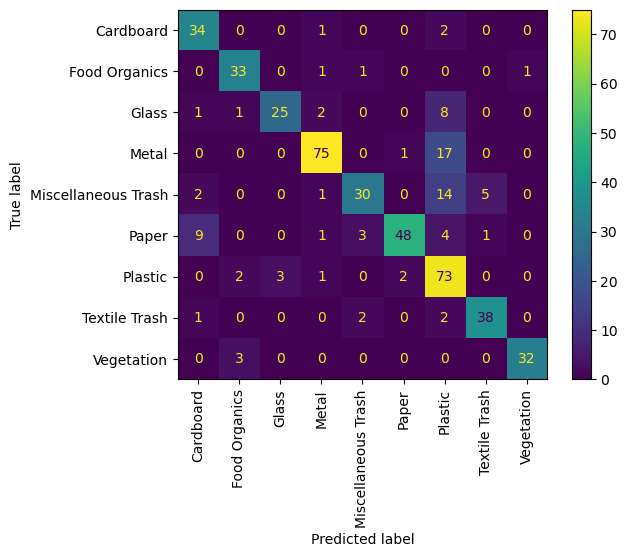

In [52]:
cm = confusion_matrix(predictions['true'],predictions['est'])
plt.figure(figsize=(10,8))
disp = ConfusionMatrixDisplay(cm,display_labels=class_names)
disp.plot(xticks_rotation=90);

So this does OK. All things considered.  However, it does appear we are quickly reaching an optimum pretty quickly so perhaps there are some tweaks we should consider.

It is interesting to see where the miscalssifications come from: it misclassifies paper with cardboard (but not vice-versa).  It also struggles with plastic...

### 2.4 Fine-tune the Model

Let's take this approach:  1) we will open up to training more than just the final custom layers; 2) we will reduce the learning rate by 75%, 3) add additional epochs, & 4) introduce an early stopping call back in the optimizer.

In [53]:
# begin by grabbing the original resnet model.
base = img_model.layers[1]
print(f'There are {len(base.layers)} in our base model.')
base

There are 175 in our base model.


<Functional name=resnet50, built=True>

In [54]:
# lets try and train the last 10% of these
base.trainable = True
unfreze_idx = int(len(base.layers) * .90)
for l in base.layers[:unfreze_idx+1]:
    l.trainable = False

In [55]:
#adjust the learning rate & epochs
new_learning_rate = 0.25 * base_learning_rate
added_epochs = original_epochs + 7

In [56]:
#Define the callback
stoppage = EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

In [57]:
loss_func=tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy')]

In [58]:
# re-Compile
optimum = tf.keras.optimizers.Adam(learning_rate=new_learning_rate)
img_model.compile(optimizer=optimum,loss=loss_func,metrics=metrics)

##### Fit the New Model

In [59]:
history_new = img_model.fit(train_ds,validation_data=validation_ds,
                            initial_epoch=history.epoch[-1], epochs=added_epochs,
                            callbacks=[stoppage])

Epoch 5/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8471 - loss: 0.4586 - val_accuracy: 0.7979 - val_loss: 0.6890
Epoch 6/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9768 - loss: 0.0951 - val_accuracy: 0.8468 - val_loss: 0.4954
Epoch 7/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9968 - loss: 0.0216 - val_accuracy: 0.8723 - val_loss: 0.5056
Epoch 8/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9985 - loss: 0.0108 - val_accuracy: 0.8681 - val_loss: 0.4459
Epoch 9/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.8787 - val_loss: 0.4620
Epoch 10/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8766 - val_loss: 0.4574
Epoch 11/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 1.0000 - loss: 4.8966e-04 - val_accuracy: 0.8830 - val_loss: 0.4639
Epoch 12/12
119/119 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 1.0000 - loss: 3.5322e-04

#### Evaluate the New Model

In [60]:
# Evaluate the model on test data
loss, accuracy = img_model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test Loss: {loss:.3f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step - accuracy: 0.9271 - loss: 0.2960
Test accuracy: 0.906
Test Loss: 0.351


Not bad!  Recall that the original model had 85% accuracy on the test data and the loss function has come down from 0.45

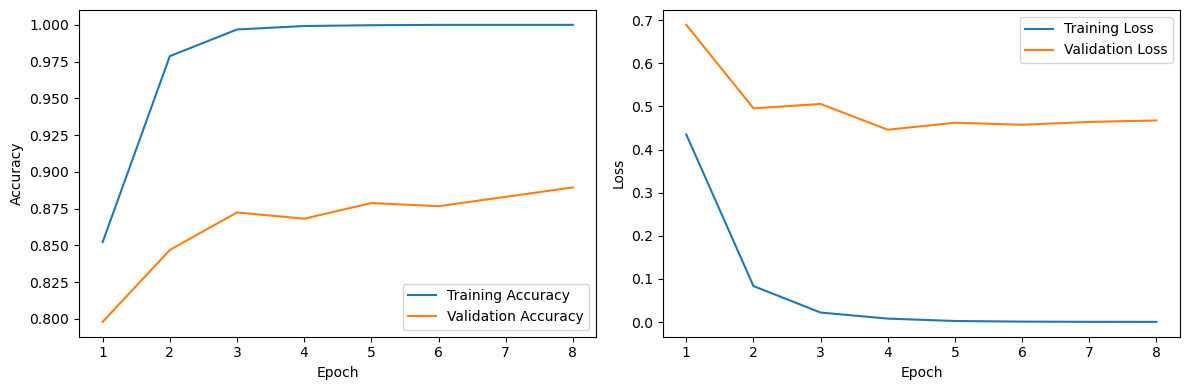

In [61]:
plot_history(history_new)

This does suggest overfitting issues...but the test data score did so well...

In [62]:
test_predictions = img_model.predict(test_dataset)
predictions = pd.DataFrame(test_predictions)
predictions['est'] = predictions.apply(lambda r:np.argmax(r),axis=1)
predictions['true'] = np.argmax(np.concatenate([y for x,y in test_dataset],axis=0),axis=1)
predictions


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 852ms/step


2025-05-24 19:34:01.592202: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,0,1,2,3,4,5,6,7,8,est,true
0,1.766602e-01,3.738611e-09,2.676582e-06,1.585616e-05,3.862651e-07,8.221954e-01,3.035646e-05,1.095121e-03,5.640780e-09,5,5
1,4.465925e-05,1.194265e-08,6.502646e-06,9.999378e-01,6.396815e-06,4.233706e-06,2.985710e-09,3.405093e-07,9.139751e-09,3,3
2,2.171705e-02,3.837946e-07,1.483737e-05,9.775609e-01,2.134008e-04,7.716783e-06,4.243341e-04,6.126369e-05,1.468778e-07,3,3
3,3.578719e-08,3.213522e-08,5.636345e-05,2.110380e-03,1.105220e-06,1.436781e-07,9.978316e-01,4.183198e-07,1.280429e-09,6,6
4,2.874830e-12,4.905731e-16,9.127922e-15,8.838420e-14,1.000000e+00,1.000271e-15,1.162271e-14,4.904928e-15,5.098840e-15,4,4
...,...,...,...,...,...,...,...,...,...,...,...
475,4.210356e-08,4.472161e-06,5.672000e-08,4.658664e-07,9.998547e-01,1.688770e-06,1.099461e-07,1.383862e-04,1.038809e-07,4,4
476,4.082520e-03,1.932124e-03,1.106194e-05,1.275414e-02,5.897062e-01,1.483610e-02,1.296464e-04,3.758724e-01,6.758764e-04,4,7
477,6.135787e-04,1.452640e-06,7.268181e-08,8.101811e-08,2.448386e-03,2.167881e-04,9.967144e-01,5.262059e-06,5.276110e-09,6,6
478,6.592061e-06,9.773581e-08,7.637064e-08,9.995263e-01,5.407014e-05,7.094153e-05,3.295591e-05,3.090474e-04,4.790275e-09,3,3


<Figure size 1000x800 with 0 Axes>

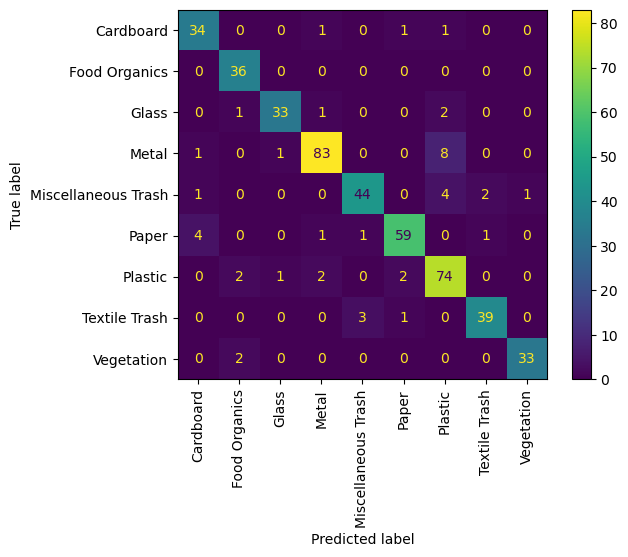

In [63]:
cm = confusion_matrix(predictions['true'],predictions['est'])
plt.figure(figsize=(10,8))
disp = ConfusionMatrixDisplay(cm,display_labels=class_names)
disp.plot(xticks_rotation=90);

We are still struggling to handle paper that is erroneously being labled as cardboard.  But a lot of the mistakes for plastic have dissapeared.

#### Save the model

In [64]:
# Save the model
model_save_path = "./image_classifier_tf.keras"
img_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./image_classifier_tf.keras


Create a function:

In [65]:
def predict_image(image_data):
    return img_model.predict(image_data)

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

Apply the text preprocessing pipeline created earlier

Option A

In [66]:
y = descriptions['category']
X = descriptions['description'].apply(lambda d: preprocess_text(d)[0])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train

4227      compact purple homemade hedge trimming
4676                          import glass sheet
800                     personal spot greet card
3671                 new spot budget copper wire
4193           personal white glass local pencil
                          ...                   
4426                               dry nut shell
466                                clean cd case
3092     fold massive black natural glass bottle
3772               small multicolored glass vase
860     clean black supermarket rubber band leak
Name: description, Length: 4000, dtype: object

In [67]:
X_train_array,X_test_array = tdif_split(X_train=X_train,X_test=X_test)

Option B

### 3.2 Implement Text Classification Model
Choose and implement a text classification model

-Option A: Traditional Model = standard cleaning, tdif feature engineering & a multinomial Naive Bayes classifier.

-Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

Option A

In [68]:
mb = MultinomialNB()

Option B

### 3.3 Train and Evaluate the Model

Train the text classification model

- Use appropriate training parameters

- Monitor training progress

Option A

In [69]:
mb.fit(X_train_array,y_train);

Option B

TODO: Evaluate model performance

- Calculate accuracy on test set

- Generate confusion matrix

- Analyze error patterns

Option A

In [70]:
predictions = mb.predict(X_test_array)
accuracy_score(y_test,predictions)

0.991

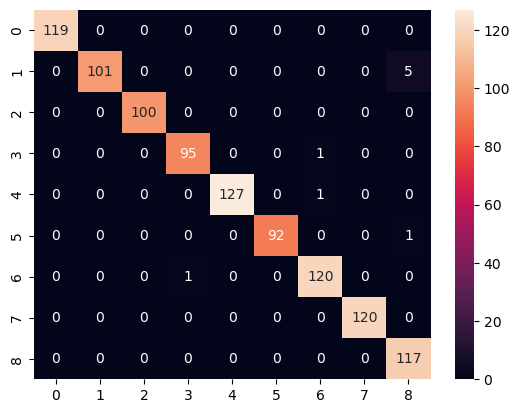

In [71]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

These results are tough to argue with...it is quick and very accurate even with the simplest processing and model implementations.

Option B

### 3.4 Create Classification Function

In [72]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    cat = class_names[mb.predict(description)]
    return cat

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval
TODO: Prepare documents for retrieval

 - Process policy documents and disposal instructions

 - Create embeddings for efficient retrieval


In [73]:
# Extract document content
documents = knowledge_base['content'].tolist()

# Create document embeddings
document_embeddings = create_document_embeddings(documents)

# Verify the shape of embeddings
if document_embeddings is not None:
    print(f"Generated embeddings with shape: {document_embeddings.shape}")
else:
    print("Embeddings not created yet.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (14, 768)


### 4.2 Implement RAG-based System
TODO: Select a pre-trained language model and implement RAG

- Choose an appropriate language model

- Create a retrieval mechanism

In [74]:
def retrieve_documents(query, embeddings, contents, metadata, top_k=3, threshold=0.3):
    """
    Retrieve the most relevant documents for a given query.
    
    Args:
        query: The patient's question
        embeddings: The precomputed document embeddings
        contents: The text content of the documents
        metadata: The metadata for each document
        top_k: Maximum number of documents to retrieve
        threshold: Minimum similarity score to include a document
        
    Returns:
        List of (content, metadata, similarity_score) tuples
    """
    # Get or initialize the embedding model (same as in create_document_embeddings)
    embedding_model =  SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Replace with your code
    
    # Embed the query
    query_embedding = embedding_model.encode([query])[0]  # Replace with your code
    
    # Calculate similarity scores between query and all documents
    # Hint: Use cosine_similarity
    similarities = cosine_similarity([query_embedding],embeddings)[0]  # Replace with your code
    
    # Filter by threshold and get top k results
    # Hint: Use list comprehension, sorting, and slicing
    filtered_indices = [i for i, score in enumerate(similarities) if score >= threshold]
    top_indices = sorted(filtered_indices,key=lambda i:similarities[i],reverse=True)[:top_k]
    # Return the top documents with their metadata and scores
    results = [(contents[i],metadata[i],similarities[i]) for i in top_indices]  # Replace with your code
    
    return results

In [75]:
# Initialize the generative model
def initialize_generator(model_name="gpt2"):
    """
    Initialize the generative model and tokenizer.
    
    Args:
        model_name: Name of the pretrained model to use
        
    Returns:
        Tokenizer and model objects
    """
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)  # Replace with your code
    model = AutoModelForCausalLM.from_pretrained(model_name)  # Replace with your code
    
    # Set padding token if needed
    # Check if pad_token exists, if not set it to eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer, model

In [76]:
# Initialize the generator
tokenizer, model = initialize_generator()
if tokenizer and model:
    print(f"Initialized {model.config._name_or_path} with {model.num_parameters()} parameters")

Initialized gpt2 with 124439808 parameters


In [77]:
def generate_rag_response(query, contents, metadata, document_embeddings, tokenizer, model, max_length=100,temp = 0.7,prob=0.9):
    """
    Generate a response using Retrieval-Augmented Generation.
    
    Args:
        query: the type of waste
        contents: List of document contents
        metadata: List of document metadata
        document_embeddings: Precomputed embeddings for the documents
        tokenizer: The tokenizer for the language model
        model: The language model for generation
        max_length: Maximum response length
        
    Returns:
        Dictionary with the generated response and the retrieved documents
    """
    # Retrieve relevant documents for the query
    
    retrieved_docs = retrieve_documents(query,document_embeddings,contents,metadata,2,0.3)  

    if retrieved_docs:
        context = '\n'.join([f'- {doc[0]}' for doc in retrieved_docs])
        prompt = f'Context information:\n{context}\n\nQuestion: How to recycle {query}\nAnswer:'
        
    else:
        prompt = f'Question:  How to recycle {query}\nAnswer: '
    
    # Tokenize the prompt
    inputs = tokenizer(prompt,return_tensors='pt',padding=True)  # Replace with your code
    
    # TGenerate the response
    # Consider including temperature, top_k, and do_sample parameters (will otherwise use greedy method)
     # Replace with your code
    with torch.no_grad():
        output_sequences = model.generate(
                                            input_ids = inputs['input_ids'],
                                            attention_mask = inputs['attention_mask'],
                                            max_length = len(inputs['input_ids'][0]) + max_length,
                                            temperature = temp,
                                            top_p = prob,
                                            do_sample = True,
                                            pad_token_id = tokenizer.pad_token_type_id
                                         )
    
    # Decode the response and extract the generated text
    response = tokenizer.decode(output_sequences[0],skip_special_tokens=True)
    response = response.replace(prompt,"").strip()  
    
    # Return the results
    return {
        "query": query,
        "response": response,
        "retrieved_documents": retrieved_docs
    }


In [78]:
# Test the RAG system with several queries
if document_embeddings is not None and tokenizer and model:
    test_queries = [
        "Paper",
        "Plastic",
        "Cardboard",
        "Vegetation"
    ]
    
    for query in test_queries:
        print(f"\nQuery: {query}")
        result = generate_rag_response(
                                        query=query,
                                        contents=documents,
                                        metadata=knowledge_base['metadata'].tolist(),
                                        document_embeddings=document_embeddings,
                                        tokenizer=tokenizer,
                                        model=model
                                    )
        
        print("\nRetrieved Documents:")
        for i, (doc, meta, score) in enumerate(result["retrieved_documents"]):
            print(f"{i+1}. [{score:.4f}] Topic: {meta['type']}, Subtopic: {' '.join(meta['coverage'])}")
        
        print(f"\nGenerated Response:\n{result['response']}")
        print("-" * 80)
else:
    print("Cannot test generation without embeddings or model.")


Query: Paper

Retrieved Documents:
1. [0.4249] Topic: Paper Recycling Guidelines, Subtopic: Paper

Generated Response:
Paper is a precious resource that is used to make products. It is used to make things like food, clothing, and even paper. It is also used to make paper for other things like paper and paper bags.

Paper is used to make many different kinds of things such as paper clips, paper cups, and paper towels. It is also used for other things such as for making paper bags and for making paper bags.

Paper is also used to make paper towels and paper towels.
--------------------------------------------------------------------------------

Query: Plastic

Retrieved Documents:
1. [0.4378] Topic: Plastic Recycling Guidelines, Subtopic: Plastic
2. [0.3057] Topic: Metal Recycling Guidelines, Subtopic: Metal

Generated Response:
Plastic is an extremely durable material. It is the most common and most valuable material for recyclers. Plastic recycling is one of the most effective ways t

### 4.3 Adjust and Evaluate the System

Some helper functions first...

In [79]:
def top_words(category,k=10):
    # Single words
    processed_tokens = descriptions[descriptions.category==category]['descriptions'].apply(preprocess_text)
    counter = Counter([token for doc in df['processed_tokens'] for token in doc])
    
    return counter.most_common(k)

In [80]:
def get_common_terms(category):
    processed_tokens = descriptions[descriptions.category==category]['description'].apply(lambda r:preprocess_text(r)[1])
    counts = Counter([token for doc in processed_tokens for token in doc])
    terms = [count[0] for count in counts.most_common(20)]
    return terms


In [81]:
def length_match(response_data):
    q_words = len(response_data['query'].split())
    r_words = len(response_data['response'].split())
    score = min(1,r_words/(q_words*3))
    return score

def term_count(response_data,terms):
    text = response_data['response'].lower()
    count = sum(term in text for term in terms)
    return count

In [82]:
def evaluate_response(response_data):
    """
    Evaluate the quality of a generated response based on various criteria.
    
    Args:
        response_data: Dictionary containing the query, response, and retrieved docs
        
    Returns:
        Evaluation metrics
    """
    # Implement at least two evaluation metrics
    # Suggestions:
    # 1. Content relevance - Check if response mentions terms from retrieved docs
    # 2. Response length appropriateness - Check if length is suitable for query
    # 3. Medical terminology usage - Check if appropriate medical terms are included
    special_terms = get_common_terms(response_data['query'])
    #Content Relevence:
    retrieved_content = [doc[0].lower() for doc in response_data['retrieved_documents']]
    response_lower = response_data['response'].lower()
    overlap = sum(1 for doc in retrieved_content if any(term in response_lower for term in doc.split()[:5]))

    metrics = {'content':overlap,
               'terminology':term_count(response_data,special_terms),
               'length': length_match(response_data)
              }  # Replace with your code
    
    return metrics


In [83]:
# Evaluate the responses for our test queries
if 'test_queries' in locals() and document_embeddings is not None and tokenizer and model:
    for query in test_queries:
        result = generate_rag_response(
            query=query,
            contents=documents,
            metadata=knowledge_base['metadata'].tolist(),
            document_embeddings=document_embeddings,
            tokenizer=tokenizer,
            model=model
        )
        
        metrics = evaluate_response(result)
        print(f"Query: {query}")
        print(f"Evaluation Metrics: {metrics}")
        print("-" * 80)
else:
    print("Cannot evaluate without test queries or necessary components.")

Query: Paper
Evaluation Metrics: {'content': 1, 'terminology': 2, 'length': 1}
--------------------------------------------------------------------------------
Query: Plastic
Evaluation Metrics: {'content': 2, 'terminology': 1, 'length': 1}
--------------------------------------------------------------------------------
Query: Cardboard
Evaluation Metrics: {'content': 2, 'terminology': 3, 'length': 1}
--------------------------------------------------------------------------------
Query: Vegetation
Evaluation Metrics: {'content': 1, 'terminology': 0, 'length': 1}
--------------------------------------------------------------------------------


### 4.4 Create Instruction Generation Function

In [84]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    result = generate_rag_response(
                query=query,
                contents=documents,
                metadata=knowledge_base['metadata'].tolist(),
                document_embeddings=document_embeddings,
                tokenizer=tokenizer,
                model=model
            )
    return result['response'],result['retrieved_documents']

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

TODO: Design an architecture that integrates all three models

- Create interfaces between components

- Handle input/output flow

### 5.2 Implement Integrated Assistant

In [85]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    if(input_type=='image'):
        predicted_category = predict_image(input_data)
    else:
        predicted_category = classify_waste_description(input_data)
    
    result['category'] = predicted_category

    result['instructions'] = generate_recycling_instructions(predicted_category)
    return result


### 5.3 Evaluate the Integrated System
TODO: Evaluate the integrated system on test cases

- Test with images from test dataset

- Test with text descriptions from test dataset

- Assess overall performance